### 1. Download data

In [25]:
import requests
import time
import pandas as pd
import sqlite3
from bs4 import BeautifulSoup

url = 'https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue'
response = requests.get(url, time.sleep(10)).text

if "Automated access to our data is prohibited" in response:
    headers = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36"}
    request = requests.get(url, headers = headers)
    time.sleep(10)
    response = request.text
if response:
    soup =  BeautifulSoup(response, 'html')
soup


<!DOCTYPE html>

<!--[if lt IE 7]>      <html class="no-js lt-ie9 lt-ie8 lt-ie7"> <![endif]-->
<!--[if IE 7]>         <html class="no-js lt-ie9 lt-ie8"> <![endif]-->
<!--[if IE 8]>         <html class="no-js lt-ie9"> <![endif]-->
<!--[if gt IE 8]><!--> <html class="no-js"> <!--<![endif]-->
<head>
<meta charset="utf-8"/>
<meta content="IE=edge,chrome=1" http-equiv="X-UA-Compatible"/>
<link href="https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue" rel="canonical"/>
<title>Tesla Revenue 2010-2023 | TSLA | MacroTrends</title>
<link href="/assets/images/icons/FAVICON/macrotrends-favicon.ico" rel="icon" type="image/x-icon"/>
<meta content="Tesla annual/quarterly revenue history and growth rate from 2010 to 2023. Revenue can be defined as the amount of money a company receives from its customers in exchange for the sales of goods or services.  Revenue is the top line item on an income statement from which all costs and expenses are subtracted to arrive at net income.    
				
				&

In [26]:
# Find all tables
tables = soup.find_all('table')
tables

[<table class="historical_data_table table">
 <thead>
 <tr>
 <th colspan="2" style="text-align:center">Tesla Annual Revenue<br/><span style="font-size:14px;">(Millions of US $)</span></th>
 </tr>
 </thead>
 <tbody>
 <tr>
 <td style="text-align:center">2023</td>
 <td style="text-align:center">$96,773</td>
 </tr>
 <tr>
 <td style="text-align:center">2022</td>
 <td style="text-align:center">$81,462</td>
 </tr>
 <tr>
 <td style="text-align:center">2021</td>
 <td style="text-align:center">$53,823</td>
 </tr>
 <tr>
 <td style="text-align:center">2020</td>
 <td style="text-align:center">$31,536</td>
 </tr>
 <tr>
 <td style="text-align:center">2019</td>
 <td style="text-align:center">$24,578</td>
 </tr>
 <tr>
 <td style="text-align:center">2018</td>
 <td style="text-align:center">$21,461</td>
 </tr>
 <tr>
 <td style="text-align:center">2017</td>
 <td style="text-align:center">$11,759</td>
 </tr>
 <tr>
 <td style="text-align:center">2016</td>
 <td style="text-align:center">$7,000</td>
 </tr>
 <

In [27]:
# Find trimestral table
trim_tables = soup.find_all(class_ = 'historical_data_table')
for t in trim_tables:
    if 'Tesla Quarterly Revenue' in str(t):
        my_table = t
my_table

<table class="historical_data_table table">
<thead>
<tr>
<th colspan="2" style="text-align:center">Tesla Quarterly Revenue<br/><span style="font-size:14px;">(Millions of US $)</span></th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:center">2023-12-31</td>
<td style="text-align:center">$25,167</td>
</tr>
<tr>
<td style="text-align:center">2023-09-30</td>
<td style="text-align:center">$23,350</td>
</tr>
<tr>
<td style="text-align:center">2023-06-30</td>
<td style="text-align:center">$24,927</td>
</tr>
<tr>
<td style="text-align:center">2023-03-31</td>
<td style="text-align:center">$23,329</td>
</tr>
<tr>
<td style="text-align:center">2022-12-31</td>
<td style="text-align:center">$24,318</td>
</tr>
<tr>
<td style="text-align:center">2022-09-30</td>
<td style="text-align:center">$21,454</td>
</tr>
<tr>
<td style="text-align:center">2022-06-30</td>
<td style="text-align:center">$16,934</td>
</tr>
<tr>
<td style="text-align:center">2022-03-31</td>
<td style="text-align:center">$18,756<

In [28]:
# Save data in a DataFrame
df_revenue = pd.DataFrame(columns = ["Date", "Revenue"])
for row in my_table.tbody.find_all('tr'): # Iterate in table rows
    col = row.find_all('td') # Save row in a list, one element per table column
    if col !=[]: # Jump empty rows
        col_date = col[0].text
        rev_date = col[1].text.replace('$','').replace(',','')
        df_revenue = pd.concat([df_revenue, pd.DataFrame({
            "Date": col_date,
            "Revenue": rev_date
        }, index = [0])], ignore_index = True)

df_revenue.head()

,Date,Revenue
0,2023-12-31,25167
1,2023-09-30,23350
2,2023-06-30,24927
3,2023-03-31,23329
4,2022-12-31,24318


### 2. Save data into a SQLite database

In [31]:
con = sqlite3.connect("Tesla_Trimestral_Revenue.db")

In [32]:
cursor = con.cursor()
cursor.execute("""CREATE TABLE revenue (Date, Revenue)""")
tuples_list = list(df_revenue.to_records(index = False)) # Save data from dataframe to a list of tuples
cursor.executemany("INSERT INTO revenue VALUES (?,?)", tuples_list)
con.commit()

In [7]:
# Check
for row in cursor.execute("SELECT * FROM revenue"):
    print(row)

('2023-12-31', '25167')
('2023-09-30', '23350')
('2023-06-30', '24927')
('2023-03-31', '23329')
('2022-12-31', '24318')
('2022-09-30', '21454')
('2022-06-30', '16934')
('2022-03-31', '18756')
('2021-12-31', '17719')
('2021-09-30', '13757')
('2021-06-30', '11958')
('2021-03-31', '10389')
('2020-12-31', '10744')
('2020-09-30', '8771')
('2020-06-30', '6036')
('2020-03-31', '5985')
('2019-12-31', '7384')
('2019-09-30', '6303')
('2019-06-30', '6350')
('2019-03-31', '4541')
('2018-12-31', '7226')
('2018-09-30', '6824')
('2018-06-30', '4002')
('2018-03-31', '3409')
('2017-12-31', '3288')
('2017-09-30', '2985')
('2017-06-30', '2790')
('2017-03-31', '2696')
('2016-12-31', '2285')
('2016-09-30', '2298')
('2016-06-30', '1270')
('2016-03-31', '1147')
('2015-12-31', '1214')
('2015-09-30', '937')
('2015-06-30', '955')
('2015-03-31', '940')
('2014-12-31', '957')
('2014-09-30', '852')
('2014-06-30', '769')
('2014-03-31', '621')
('2013-12-31', '615')
('2013-09-30', '431')
('2013-06-30', '405')
('2013-0

### 3.Data visualization

/tmp/ipykernel_26957/2400393938.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tesla_revenue["Date"] = pd.to_datetime(tesla_revenue["Date"])
/tmp/ipykernel_26957/2400393938.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tesla_revenue["Revenue"] = tesla_revenue["Revenue"].astype('int')


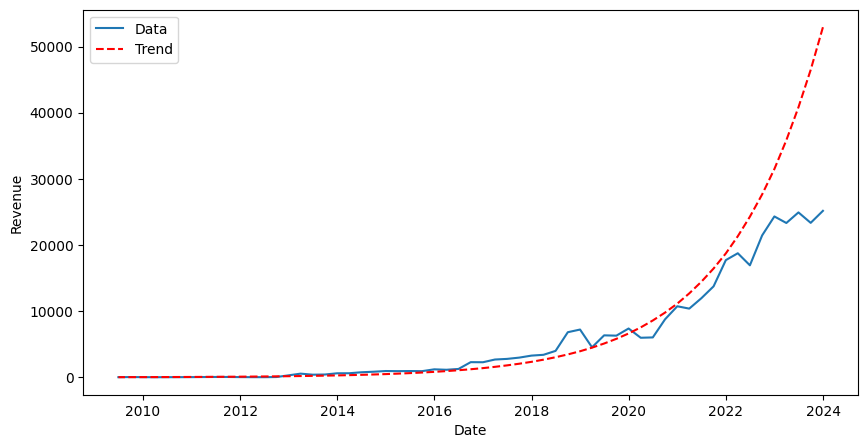

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

tesla_revenue = df_revenue
tesla_revenue = tesla_revenue.dropna(subset=['Revenue'])

fig, axis = plt.subplots(figsize = (10, 5))

tesla_revenue["Date"] = pd.to_datetime(tesla_revenue["Date"])
tesla_revenue["Revenue"] = tesla_revenue["Revenue"].astype('int')
sns.lineplot(data = tesla_revenue, x = "Date", y = "Revenue", label = 'Data')

x = tesla_revenue["Date"].index.values.astype(float)
y = np.log(tesla_revenue["Revenue"].values)
coef = np.polyfit(x, y, 1)
trendline = np.exp(coef[1]) * np.exp(coef[0] * x)

plt.plot(tesla_revenue["Date"], trendline, color='red', linestyle='--', label = 'Trend')
plt.legend()

While up until 2022 the company followed an exponential increase in profits, this trend has slowed since then, and now it seems that profits are stable around $24,000

<Figure size 1000x500 with 0 Axes>

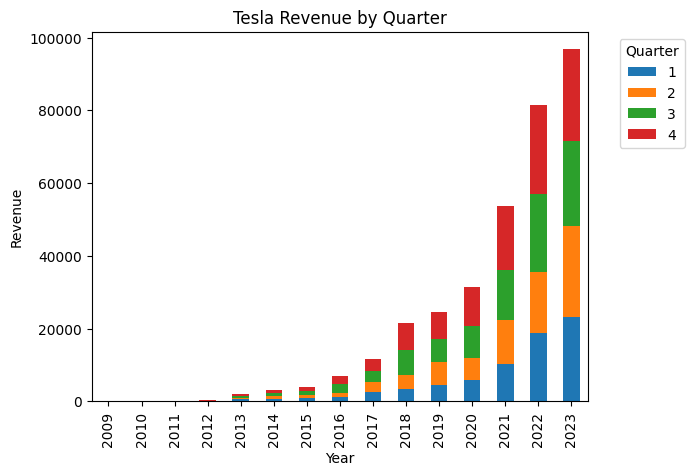

In [65]:
# Compare quarters in each year
df_revenue['Year'] = df_revenue['Date'].dt.year
df_revenue['Quarter'] = df_revenue['Date'].dt.quarter

tesla_revenue = df_revenue.dropna(subset=['Revenue'])
revenue_by_quarter = tesla_revenue.groupby(['Year', 'Quarter'])['Revenue'].sum()
revenue_by_quarter_unstacked = revenue_by_quarter.unstack()


plt.figure(figsize=(10, 5))
revenue_by_quarter_unstacked.plot(kind='bar', stacked=True)

plt.xlabel('Year')
plt.ylabel('Revenue')
plt.title('Tesla Revenue by Quarter')

plt.legend(title='Quarter', bbox_to_anchor=(1.05, 1), loc='upper left')

In each year, it seems to be a better incomes in the 4th quarter of the year.